In [1]:

import pyspark
import os
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.ml.feature import Imputer
import pandas as pd
import tensorflow # Imports tensorflow
import keras # Imports keras

Using TensorFlow backend.


In [2]:
from pyspark.sql.functions import *
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, VectorSlicer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [5]:
conf=SparkConf().setMaster("local")
sc=SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [4]:
sc.stop()

In [6]:
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data.csv')
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Temerrut_flag: integer (nullable = true)
 |-- Basvuru_tarihi: string (nullable = true)
 |-- Kullanim_orani: double (nullable = true)
 |-- Musteri_yasi: integer (nullable = true)
 |-- Dpd_30_adeti: integer (nullable = true)
 |-- Borcun_gelire_orani: double (nullable = true)
 |-- Gelir: double (nullable = true)
 |-- Acik_kredi_sayisi: integer (nullable = true)
 |-- Onceki_temerrut_sayisi: integer (nullable = true)
 |-- Acik_ev_kredi_sayisi: integer (nullable = true)
 |-- Son_2_yil_dpd_31_60_adeti: integer (nullable = true)
 |-- Bakmakla_yukumlu_kisi_sayisi: double (nullable = true)
 |-- Guncel_yil_ort_vdsz_mev_tutari: double (nullable = true)
 |-- Onceki_yil_max_vdsz_mev_tutari: double (nullable = true)
 |-- Onceki_yil_min_vdsz_mev_tutari: double (nullable = true)
 |-- Rotatif_krediler_kullanim_orani: string (nullable = true)
 |-- Kredi_vadesi: string (nullable = true)
 |-- Guncel_yil_gunluk_ort_kk_risk_tuta

In [7]:
drop_list = ['_c0', 'ID', 'Basvuru_tarihi']
data = data.select([column for column in data.columns if column not in drop_list])

In [8]:
from pyspark.sql.functions import col, count, isnan, lit, sum

def count_not_null(c, nan_as_null=False):
    """Use conversion between boolean and integer
    - False -> 0
    - True ->  1
    """
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)

In [9]:
exprs = [(count_not_null(c) / count("*")).alias(c) for c in data.columns]
completeness = data.agg(*exprs).toPandas()

In [10]:
completeness.to_dict()

{'Temerrut_flag': {0: 1.0},
 'Kullanim_orani': {0: 1.0},
 'Musteri_yasi': {0: 1.0},
 'Dpd_30_adeti': {0: 1.0},
 'Borcun_gelire_orani': {0: 1.0},
 'Gelir': {0: 1.0},
 'Acik_kredi_sayisi': {0: 1.0},
 'Onceki_temerrut_sayisi': {0: 1.0},
 'Acik_ev_kredi_sayisi': {0: 1.0},
 'Son_2_yil_dpd_31_60_adeti': {0: 1.0},
 'Bakmakla_yukumlu_kisi_sayisi': {0: 0.97384},
 'Guncel_yil_ort_vdsz_mev_tutari': {0: 0.7908733333333333},
 'Onceki_yil_max_vdsz_mev_tutari': {0: 0.7909466666666667},
 'Onceki_yil_min_vdsz_mev_tutari': {0: 0.7909733333333333},
 'Rotatif_krediler_kullanim_orani': {0: 0.7896733333333333},
 'Kredi_vadesi': {0: 1.0},
 'Guncel_yil_gunluk_ort_kk_risk_tutari': {0: 0.36102},
 'Guncel_vdsz_mev_tutari': {0: 0.028373333333333334},
 'SGK_kodu': {0: 0.01058},
 'Evin_sahiplik_durumu': {0: 1.0},
 'Istenen_evin_fiyati': {0: 1.0},
 'Toplam_calisma_suresi': {0: 0.2904},
 'Onceki_yil_ort_vdsz_mev_tutari': {0: 0.028373333333333334},
 'Calisma_tipi': {0: 1.0},
 'Son_1_yil_kredi_basvuru_sayisi': {0: 1.0}

In [11]:
drop_list = ['Bakmakla_yukumlu_kisi_sayisi', 'Guncel_yil_ort_vdsz_mev_tutari', 'Onceki_yil_max_vdsz_mev_tutari',
            'Onceki_yil_min_vdsz_mev_tutari', 'Rotatif_krediler_kullanim_orani', 'Guncel_yil_gunluk_ort_kk_risk_tutari',
            'Guncel_vdsz_mev_tutari', 'SGK_kodu', 'Toplam_calisma_suresi', 'Onceki_yil_ort_vdsz_mev_tutari', 'KK_limiti',
            'En_son_calisma_gun_sayisi', 'Isyeri_tel_no']
data = data.select([column for column in data.columns if column not in drop_list])
data.printSchema()

root
 |-- Temerrut_flag: integer (nullable = true)
 |-- Kullanim_orani: double (nullable = true)
 |-- Musteri_yasi: integer (nullable = true)
 |-- Dpd_30_adeti: integer (nullable = true)
 |-- Borcun_gelire_orani: double (nullable = true)
 |-- Gelir: double (nullable = true)
 |-- Acik_kredi_sayisi: integer (nullable = true)
 |-- Onceki_temerrut_sayisi: integer (nullable = true)
 |-- Acik_ev_kredi_sayisi: integer (nullable = true)
 |-- Son_2_yil_dpd_31_60_adeti: integer (nullable = true)
 |-- Kredi_vadesi: string (nullable = true)
 |-- Evin_sahiplik_durumu: string (nullable = true)
 |-- Istenen_evin_fiyati: integer (nullable = true)
 |-- Calisma_tipi: integer (nullable = true)
 |-- Son_1_yil_kredi_basvuru_sayisi: integer (nullable = true)
 |-- Son_6_ay_kredi_basvuru_sayisi: integer (nullable = true)
 |-- Son_3_ay_kredi_basvuru_sayisi: integer (nullable = true)
 |-- Son_2_yil_kabul_edilmis_kredi_sayisi: integer (nullable = true)
 |-- Son_1_yil_kabul_edilmis_kredi_sayisi: integer (nullable

In [12]:
## Feature Selection with Feature Importance Score
data.describe().toPandas() #Default rate oranı 6,68%

,summary,Temerrut_flag,Kullanim_orani,Musteri_yasi,Dpd_30_adeti,Borcun_gelire_orani,Gelir,Acik_kredi_sayisi,Onceki_temerrut_sayisi,Acik_ev_kredi_sayisi,...,KK_flag,Dissal_kredi_skoru,Evin_yasi,Evin_bulundugu_sok_ort_ev_yasi,Yasadigi_yerin_nufus_yogunlugu,Arac_yasi,Arac_flag,Son_12_ay_kk_kullanim_orani,Son_6_ay_kk_kullanim_orani,Son_3_ay_kk_kullanim_orani
0,count,150000,150000,150000,150000,150000,150000,150000,150000,150000,...,150000,150000,150000,150000,150000,150000,150000,150000,150000,150000
1,mean,0.06684,0.3191958274812765,52.295206666666665,0.30208666666666667,1.2869633745276492,6670.221237396816,8.45276,0.26597333333333334,1.01824,...,0.5017,1499.5202333333334,1.051883073333331,1.1313164188399727,0.020863774200010066,3.00126,0.37477333333333335,0.5269471087855635,0.6094595195927325,0.6236508695457744
2,stddev,0.24974553092872043,0.3494813808829608,14.771865863100352,2.1134537508701925,1.884543943661449,12880.445756228004,5.145950989643292,4.169303787594438,1.1297709848828545,...,0.4999987766570161,288.6729169682646,0.5490326029846994,0.6101384946398969,0.013814647806887136,4.693336261314281,0.4840659501430059,0.14781774882044998,0.22824408278007977,0.2213779180692427
3,min,0,0.0,0,0,0.0,0.0,0,0,0,...,0,1000,0.1,0.085951,5.33E-4,0.0,0,0.009999999,0.00436927179,0.054369266789999995
4,max,1,1.0,109,98,5.0,3008750.0,58,98,54,...,1,2000,2.0,2.5987,0.072508,15.0,1,1.0,1.0,1.0


In [13]:
#Data Preprocessing
# one hot encoding and assembling
#encoding_var = [i[0] for i in df.dtypes if (i[1]=='string') & (i[0]!='y')]
num_var = [i[0] for i in data.dtypes if ((i[1]=='int') | (i[1]=='double')) & (i[0]!='Temerrut_flag')]

#string_indexes = [StringIndexer(inputCol = c, outputCol = 'IDX_' + c, handleInvalid = 'keep') for c in encoding_var]
#onehot_indexes = [OneHotEncoderEstimator(inputCols = ['IDX_' + c], outputCols = ['OHE_' + c]) for c in encoding_var]
#label_indexes = StringIndexer(inputCol = 'y', outputCol = 'label', handleInvalid = 'keep')
assembler = VectorAssembler(inputCols = num_var , outputCol = "features")
rf = RandomForestClassifier(labelCol="Temerrut_flag", featuresCol="features", seed = 8464,
                            numTrees=10, cacheNodeIds = True, subsamplingRate = 0.7)

pipe = Pipeline(stages = [assembler,rf])

In [14]:
assembled = assembler.transform(data)

In [19]:
assembled.select("features").rdd.take(10)

[Row(features=DenseVector([0.7661, 45.0, 2.0, 0.803, 9120.0, 13.0, 0.0, 6.0, 0.0, 959346.0, 5.0, 4.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1926.0, 1.198, 1.3286, 0.0188, 12.0, 1.0, 0.4577, 0.458, 0.4963])),
 Row(features=DenseVector([0.9572, 40.0, 0.0, 0.1219, 2600.0, 4.0, 0.0, 0.0, 0.0, 613856.0, 3.0, 4.0, 3.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1596.0, 1.93, 1.9628, 0.0035, 2.0, 1.0, 0.4096, 0.4012, 0.4491])),
 Row(features=DenseVector([0.6582, 38.0, 1.0, 0.0851, 3042.0, 2.0, 1.0, 0.0, 0.0, 412920.0, 6.0, 4.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1802.0, 1.836, 2.3152, 0.01, 7.0, 1.0, 0.3866, 0.3809, 0.4138])),
 Row(features=DenseVector([0.2338, 30.0, 0.0, 0.036, 3300.0, 5.0, 0.0, 0.0, 0.0, 978835.0, 3.0, 2.0, 1.0, 1.0, 3.0, 2.0, 2.0, 0.0, 1.0, 1801.0, 1.196, 1.5237, 0.008, 12.0, 1.0, 0.3023, 0.3004, 0.3121])),
 Row(features=DenseVector([0.9072, 49.0, 1.0, 0.0249, 63588.0, 7.0, 0.0, 1.0, 0.0, 919228.0, 4.0, 3.0, 2.0, 2.0, 5.0, 4.0, 3.0, 1.0, 1.0, 1068.0, 1.201, 1.5565, 0.0287, 1.0, 1.0, 0.499

In [13]:
mod = pipe.fit(data)

In [14]:
data2 = mod.transform(data)

In [15]:
mod.stages[-1].featureImportances

SparseVector(28, {0: 0.2154, 1: 0.0087, 2: 0.1198, 3: 0.0037, 4: 0.0004, 5: 0.0062, 6: 0.4474, 7: 0.002, 8: 0.1572, 9: 0.0009, 11: 0.0005, 13: 0.0003, 14: 0.0004, 15: 0.0008, 16: 0.0003, 17: 0.0001, 19: 0.0007, 20: 0.0002, 21: 0.0006, 22: 0.0006, 23: 0.0003, 25: 0.0144, 26: 0.003, 27: 0.0162})

In [16]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [17]:
ExtractFeatureImp(mod.stages[-1].featureImportances, data2, "features").head(10)

,idx,name,score
6,6,Onceki_temerrut_sayisi,0.447381
0,0,Kullanim_orani,0.215441
8,8,Son_2_yil_dpd_31_60_adeti,0.157214
2,2,Dpd_30_adeti,0.119814
27,27,Son_3_ay_kk_kullanim_orani,0.016186
25,25,Son_12_ay_kk_kullanim_orani,0.014386
1,1,Musteri_yasi,0.008653
5,5,Acik_kredi_sayisi,0.006212
3,3,Borcun_gelire_orani,0.003655
26,26,Son_6_ay_kk_kullanim_orani,0.002985


In [18]:
var_list = ExtractFeatureImp(mod.stages[-1].featureImportances, data2, "features").head(10)
var_list.iloc[:,1:3]

,name,score
6,Onceki_temerrut_sayisi,0.447381
0,Kullanim_orani,0.215441
8,Son_2_yil_dpd_31_60_adeti,0.157214
2,Dpd_30_adeti,0.119814
27,Son_3_ay_kk_kullanim_orani,0.016186
25,Son_12_ay_kk_kullanim_orani,0.014386
1,Musteri_yasi,0.008653
5,Acik_kredi_sayisi,0.006212
3,Borcun_gelire_orani,0.003655
26,Son_6_ay_kk_kullanim_orani,0.002985


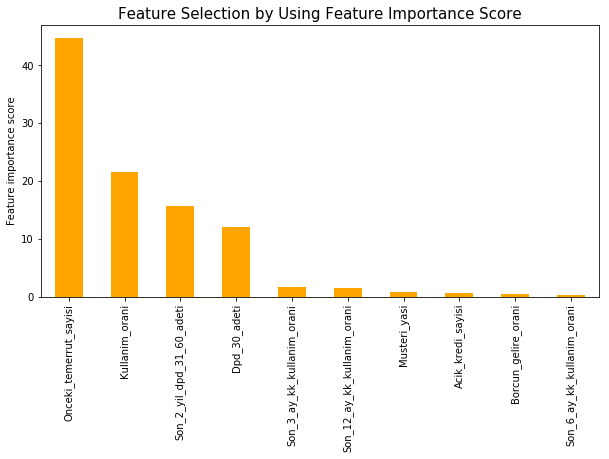

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
score = var_list['score']*100
name = var_list['name']
FeatureImportance = {"Score":score, "Feature" : name}
FeatureImportance = pd.DataFrame(FeatureImportance)

FeatureImportance.plot(figsize = (10,5), kind = "bar", color = "orange",
                               x = "Feature", y = "Score", legend = False)

plt.xlabel("", fontsize = 10)
plt.ylabel("Feature importance score", fontsize = 10)
plt.title("Feature Selection by Using Feature Importance Score", fontsize = 15)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

In [57]:
idx = var_list['idx']

In [44]:
#### Logistic regression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
log_data = data[['Temerrut_flag','Onceki_temerrut_sayisi', 'Kullanim_orani', 'Son_2_yil_dpd_31_60_adeti','Son_3_ay_kk_kullanim_orani', 
               'Son_12_ay_kk_kullanim_orani', 'Musteri_yasi', 'Acik_kredi_sayisi', 'Borcun_gelire_orani', 'Son_6_ay_kk_kullanim_orani']]

In [68]:
# Transform all features into a vector using VectorAssembler. 
del assembler
categoricalColumns = []
stages = []
numericCols = ['Onceki_temerrut_sayisi', 'Kullanim_orani', 'Son_2_yil_dpd_31_60_adeti','Son_3_ay_kk_kullanim_orani', 
               'Son_12_ay_kk_kullanim_orani', 'Musteri_yasi', 'Acik_kredi_sayisi', 'Borcun_gelire_orani', 'Son_6_ay_kk_kullanim_orani']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
label_stringIdx = StringIndexer(inputCol = 'Temerrut_flag', outputCol="label")
stages += [label_stringIdx]

In [75]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(log_data)
preppedDataDF = pipelineModel.transform(log_data)

In [70]:
# Fit model to prepped data
lrModel = LogisticRegression().fit(preppedDataDF)

In [80]:
cols = log_data.columns
selectedcols = ["label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print('Train dataset obs count:',trainingData.count())
print('Test dataset obs count:', testData.count())

Train dataset obs count: 105045
Test dataset obs count: 44955


In [81]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)

In [82]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.79128319512507

In [83]:
roc = evaluator.evaluate(predictions)
gini= (2*roc)-1; 
print('Logistic regression gini value is:', gini)

Logistic regression gini value is: 0.5825663902501399


# Confusion Matrix for Logistic Regression

In [86]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracylr = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracylr))
print(accuracylr)

Test Error = 0.0668891
0.9331108886664442


In [114]:
y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[41923,    31],
       [ 2976,    25]], dtype=int64)

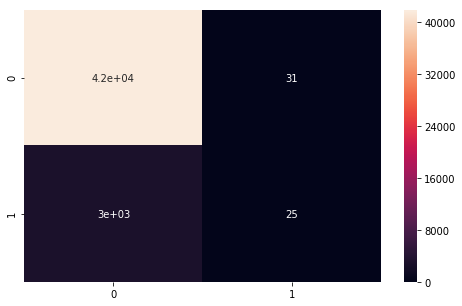

In [106]:
import seaborn as sns
plt.figure(figsize = (8,5))
sn.heatmap(cnf_matrix, annot=True)

# Random Forest

In [115]:
# Random Forest
# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
# Train model with Training Data
rfModel = rf.fit(trainingData)

In [116]:
# Make predictions on test data using the Transformer.transform() method.
predictions_r = rfModel.transform(testData)

In [117]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions_r)

0.8237494193391259

In [118]:
roc_r = evaluator.evaluate(predictions_r)
gini_r = (2*roc_r)-1; 
print('Random forest gini value is:', gini_r)

Random forest gini value is: 0.6474988386782519


# Confusion Matrix for Random Forest

In [130]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracyrf = evaluator.evaluate(predictions_r)
print("Test Error = %g" % (1.0 - accuracyrf))
print(accuracyrf)

Test Error = 0.0634857
0.9365142920698476


In [138]:
y_true = predictions_r.select("label")
y_true = y_true.toPandas()
y_pred = predictions_r.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[41831,   123],
       [ 2731,   270]], dtype=int64)

# Decision Tree

In [121]:
#Decision Tree
# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)

# Train model with Training Data
dtModel = dt.fit(trainingData)

In [122]:
print("numNodes = ", dtModel.numNodes)
print("depth = ", dtModel.depth)

numNodes =  7
depth =  3


In [133]:
# Make predictions on test data using the Transformer.transform() method.
predictions_dt = dtModel.transform(testData)

In [134]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions_dt)

0.3390419930735456

In [135]:
gini_dt = evaluator.evaluate(predictions_dt)
print('Decision tree gini value is:', gini_dt)

Decision tree gini value is: 0.3390419930735456


# Confusion Matrix for Decision Tree

In [136]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracydt = evaluator.evaluate(predictions_dt)

In [127]:
print("Test Error = %g" % (1.0 - accuracydt))
print(accuracydt)

Test Error = 0.0643532
0.9356467578689801


In [137]:
y_true = predictions_dt.select("label")
y_true = y_true.toPandas()
y_pred = predictions_dt.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix

array([[41831,   123],
       [ 2731,   270]], dtype=int64)